## imports

* do gravity corr with lpf
* check lin acc freq 
* run test cases
* check compressed files with java
add these to readme
read on room database


In [2]:
from scipy import fftpack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## utils

In [2]:
def cyc_sec(time_vec): #calculate  cycles per second
    n = time_vec.iloc[0]
    avgs = []
    while n < time_vec.iloc[-1]:
        recs = len(time_vec[(time_vec >n) & (time_vec<n+ 1e+9)])
        avgs.append(recs)
        n= n+1e+9
    plt.plot(avgs)
    return round(np.mean(avgs)),round(np.std(avgs))

In [3]:
def fft_signal(signal,time_step):
    mean = signal.mean()
    sig =signal-mean #normalization
    time_step = 1./time_step
    # time_vec  = time
    sig_fft = fftpack.fft(sig)
    amplitude  = np.abs(sig_fft)
    power = amplitude**2
    # angle  = np.angle(sig_fft)
    sample_freq = fftpack.fftfreq(sig.size,d=time_step)
    amp_freq = np.array([power,sample_freq])
    return sample_freq,amp_freq #returnung the freq, psd

In [4]:
def filtered_sig(signal,step,threshold=0.4):
    fourier = fftpack.rfft(signal)
    frequencies = fftpack.rfftfreq(signal.size, d=step) #d should be sampling rate
    print(frequencies.max(),signal.size)
    print("threshold is: ",threshold)
    fourier[frequencies > threshold] = 0
    filtered = fftpack.irfft(fourier)
    return filtered

## stationary data

In [5]:
df  =pd.read_csv('/Users/atufasheen/Desktop/projects/meiro_work/EP1_Stationary on mobile phone stand on table, slight tilt-jerk at the end.csv',
                    sep=';',names=['time','type','x','y','z','ang_x','ang_y','ang_z'])
df.shape[0]

108723

In [6]:
df = df[df['type']==' ACC'][['time','x','y','z']]
df.shape[0]

31096

In [7]:
df[(df['time'] >=45405606769106) & (df['time']<=45405606769106+ 1e+9)] # events in first sec

,time,x,y,z
1,45405606769106,0.113876,7.368317,6.121399
2,45405609271547,0.057617,7.419800,6.127396
3,45405611773989,0.067200,7.394653,6.077118
4,45405614277065,0.061203,7.393463,6.123795
5,45405616810024,0.071976,7.389862,6.122604
...,...,...,...,...
1270,45406595752895,0.088745,7.339584,6.189636
1273,45406598255337,0.085144,7.337189,6.165695
1277,45406600757778,0.104309,7.417404,6.151337
1280,45406603260219,0.082748,7.400635,6.172882


* the second (for deltaT) starts from the first value in the data

394 42


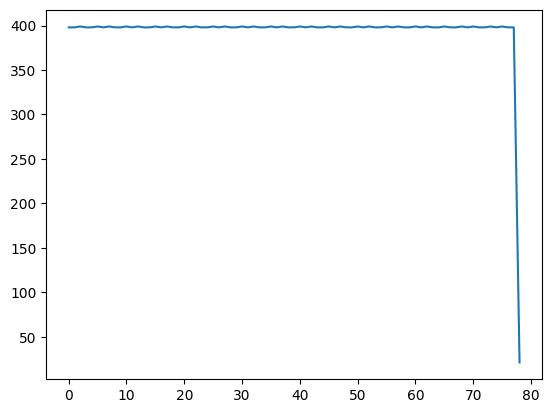

In [8]:
avg,std  = cyc_sec(df['time'])
print(avg,std)

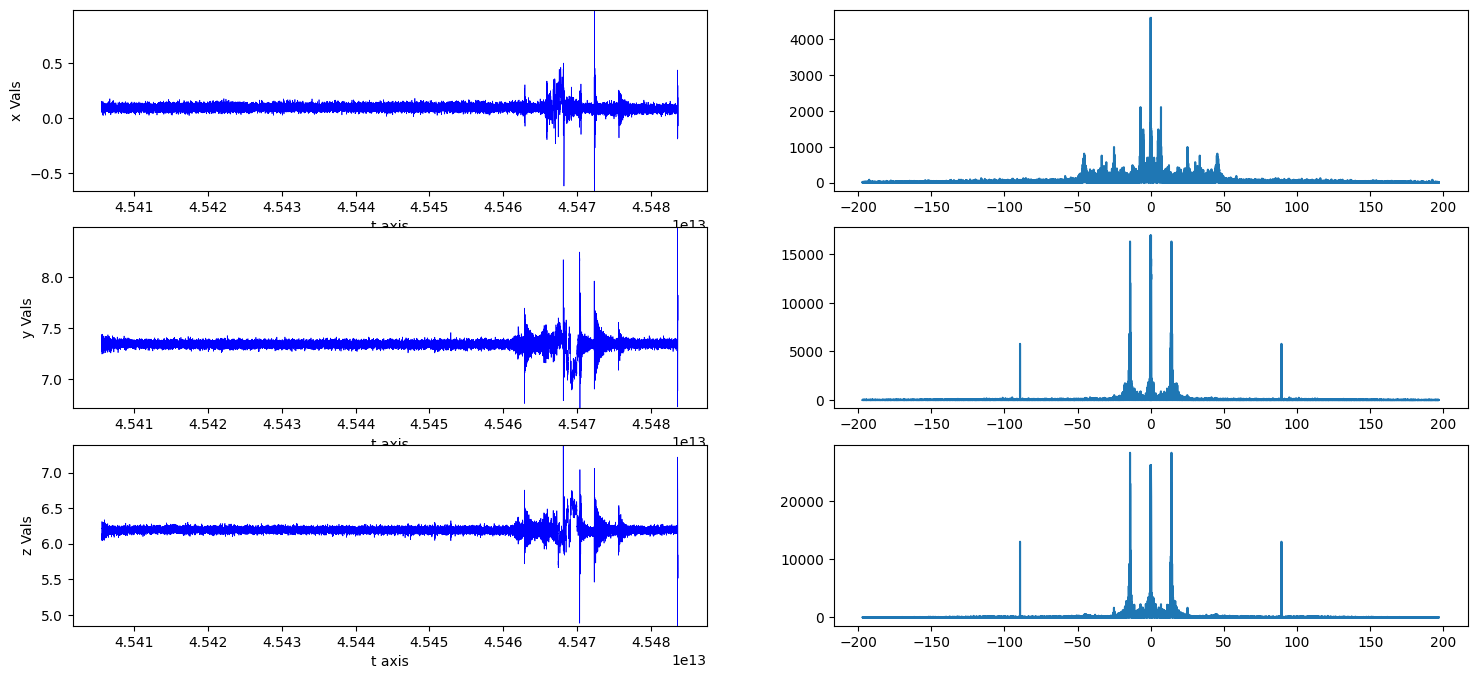

In [9]:
accs = ['x','y','z']
fig, ax = plt.subplots(3,2,figsize=(18,8))
for i in range(len(accs)):
    signal  = df[accs[i]].values
    time  = df['time'].values
    sample_freq,amp_freq = fft_signal(signal,avg)
    minsignal, maxsignal = signal.min(), signal.max()

    ax[i,0].plot(time, signal, color='b', lw=0.5, label='Noisy Signal')
    ax[i,0].set_ylim([minsignal, maxsignal])
    ax[i,0].set_xlabel('t axis')
    ax[i,0].set_ylabel(f'{accs[i]} Vals')
    ax[i,1].plot(sample_freq,amp_freq[0,:],label = 'psd')
# fig.savefig('output/stationary')

## treated stationary data

In [6]:
df = pd.read_csv('/Users/atufasheen/Desktop/projects/meiro_work/EP1_Stationary on mobile phone stand on table, slight tilt-jerk at the end.csv'
                    ,sep=';',names=['time','type','x','y','z','ang_x','ang_y','ang_z'])

* difference between two time steps on y-axis

### Pretreat df: filling the missing data with smallest deltaT throughout the data
at larget deltaT value

In [ ]:
df2 = pd.DataFrame({'time':[],'x':[],'y':[],'z':[]})
dff = df.copy()
n = dff['time'].iloc[0]
x = list(np.diff(np.diff(dff['time'])))
x.insert(0,0)
x.insert(0,0)
dff['time_diff'] = x 
desc = dff[dff['time_diff']==0].describe().T[['mean','min','50%']].T 
while (n < dff['time'].iloc[-1]):
    recs = dff[(dff['time'] >=n) & (dff['time']<n+ 1e+9)].copy()
    # df2.iloc[counter:counter + len(recs)] = recs
    df2 = pd.concat([df2,recs],axis=0)
    if len(recs) < 400:
        t = 400-len(recs)
        # filling the missing data with smallest deltaT within the second
        recs = pd.DataFrame({'time':np.arange(df2['time'].iloc[-1]+1,df2['time'].iloc[-1]+t+1),'x':[desc['x']['min']]*t,'y':[desc['y']['min']]*t,'z':[desc['z']['min']]*t}) # 
        # df2.iloc[counter + len(recs):counter + len(recs) + (400-len(recs))] = 0
        df2 = pd.concat([df2,recs],axis=0)
    n= n+1e+9
print(df2.shape)
# df2.to_csv('cleaned_stationary_df.csv',index=False)

## Calculate Linear ACC

### By defining alpha values 

In [34]:
dt =1./400
T = len(df['x'])
alpha = T/ (T+dt)
print(alpha)

In [16]:
gx = 0
gy = 0
gz = 0

def grav_x(ax):
    global gx
    alpha = 0.99
    val = alpha*gx+(1-alpha)*ax
    gx = val
    return val

def grav_y(ay):
    global gy
    alpha = 0.99
    val = alpha*gy+(1-alpha)*ay
    gy = val
    return val

def grav_z(az):
    global gz
    alpha = 0.99
    val = alpha*gz+(1-alpha)*az
    gz = val
    return val

In [17]:
df['gx'] = df['x'].apply(lambda x: grav_x(x))
df['gy'] = df['y'].apply(lambda x: grav_y(x))
df['gz'] = df['z'].apply(lambda x: grav_z(x))

In [19]:
df['lin_acc_x'] = df['x'] - df['gx']
df['lin_acc_y'] = df['y'] - df['gy']
df['lin_acc_z'] = df['z'] - df['gz']

In [20]:
df.head()

,time,type,x,y,z,ang_x,ang_y,ang_z,gx,gy,gz,lin_acc_x,lin_acc_y,lin_acc_z
0,45405604266664,ACC,0.154587,7.270157,6.135773,0.0,0.0,0.0,0.001546,0.072702,0.061358,0.153041,7.197455,6.074415
1,45405606769106,ACC,0.113876,7.368317,6.121399,0.0,0.0,0.0,0.002669,0.145658,0.121958,0.111207,7.222659,5.999441
2,45405609271547,ACC,0.057617,7.419800,6.127396,0.0,0.0,0.0,0.003219,0.218399,0.182013,0.054398,7.201401,5.945383
3,45405611773989,ACC,0.067200,7.394653,6.077118,0.0,0.0,0.0,0.003858,0.290162,0.240964,0.063342,7.104491,5.836154
4,45405614277065,ACC,0.061203,7.393463,6.123795,0.0,0.0,0.0,0.004432,0.361195,0.299792,0.056771,7.032268,5.824003


### By defining alpha value

In [11]:
df = pd.read_csv('/Users/atufasheen/Desktop/projects/meiro_work/EP1_Stationary on mobile phone stand on table, slight tilt-jerk at the end.csv'
                    ,sep=';',names=['time','type','x','y','z','ang_x','ang_y','ang_z'])

In [12]:
df = df[400:(400*8)]

In [18]:
def low_pass_filter(data, alpha):
    # calculate the time constant
    # tau = 1/(2*np.pi*cutoff_freq)
    # calculate the alpha
    # alpha = sample_freq*tau/(sample_freq*tau + 1)
    print(alpha)
    # initialize the filtered data array
    filtered_data = [data.iloc[0]]
    for i in range(1, len(data)):
        filtered_data.append(alpha*data.iloc[i] + (1-alpha)*filtered_data[i-1])
    return filtered_data


0.001
0.01


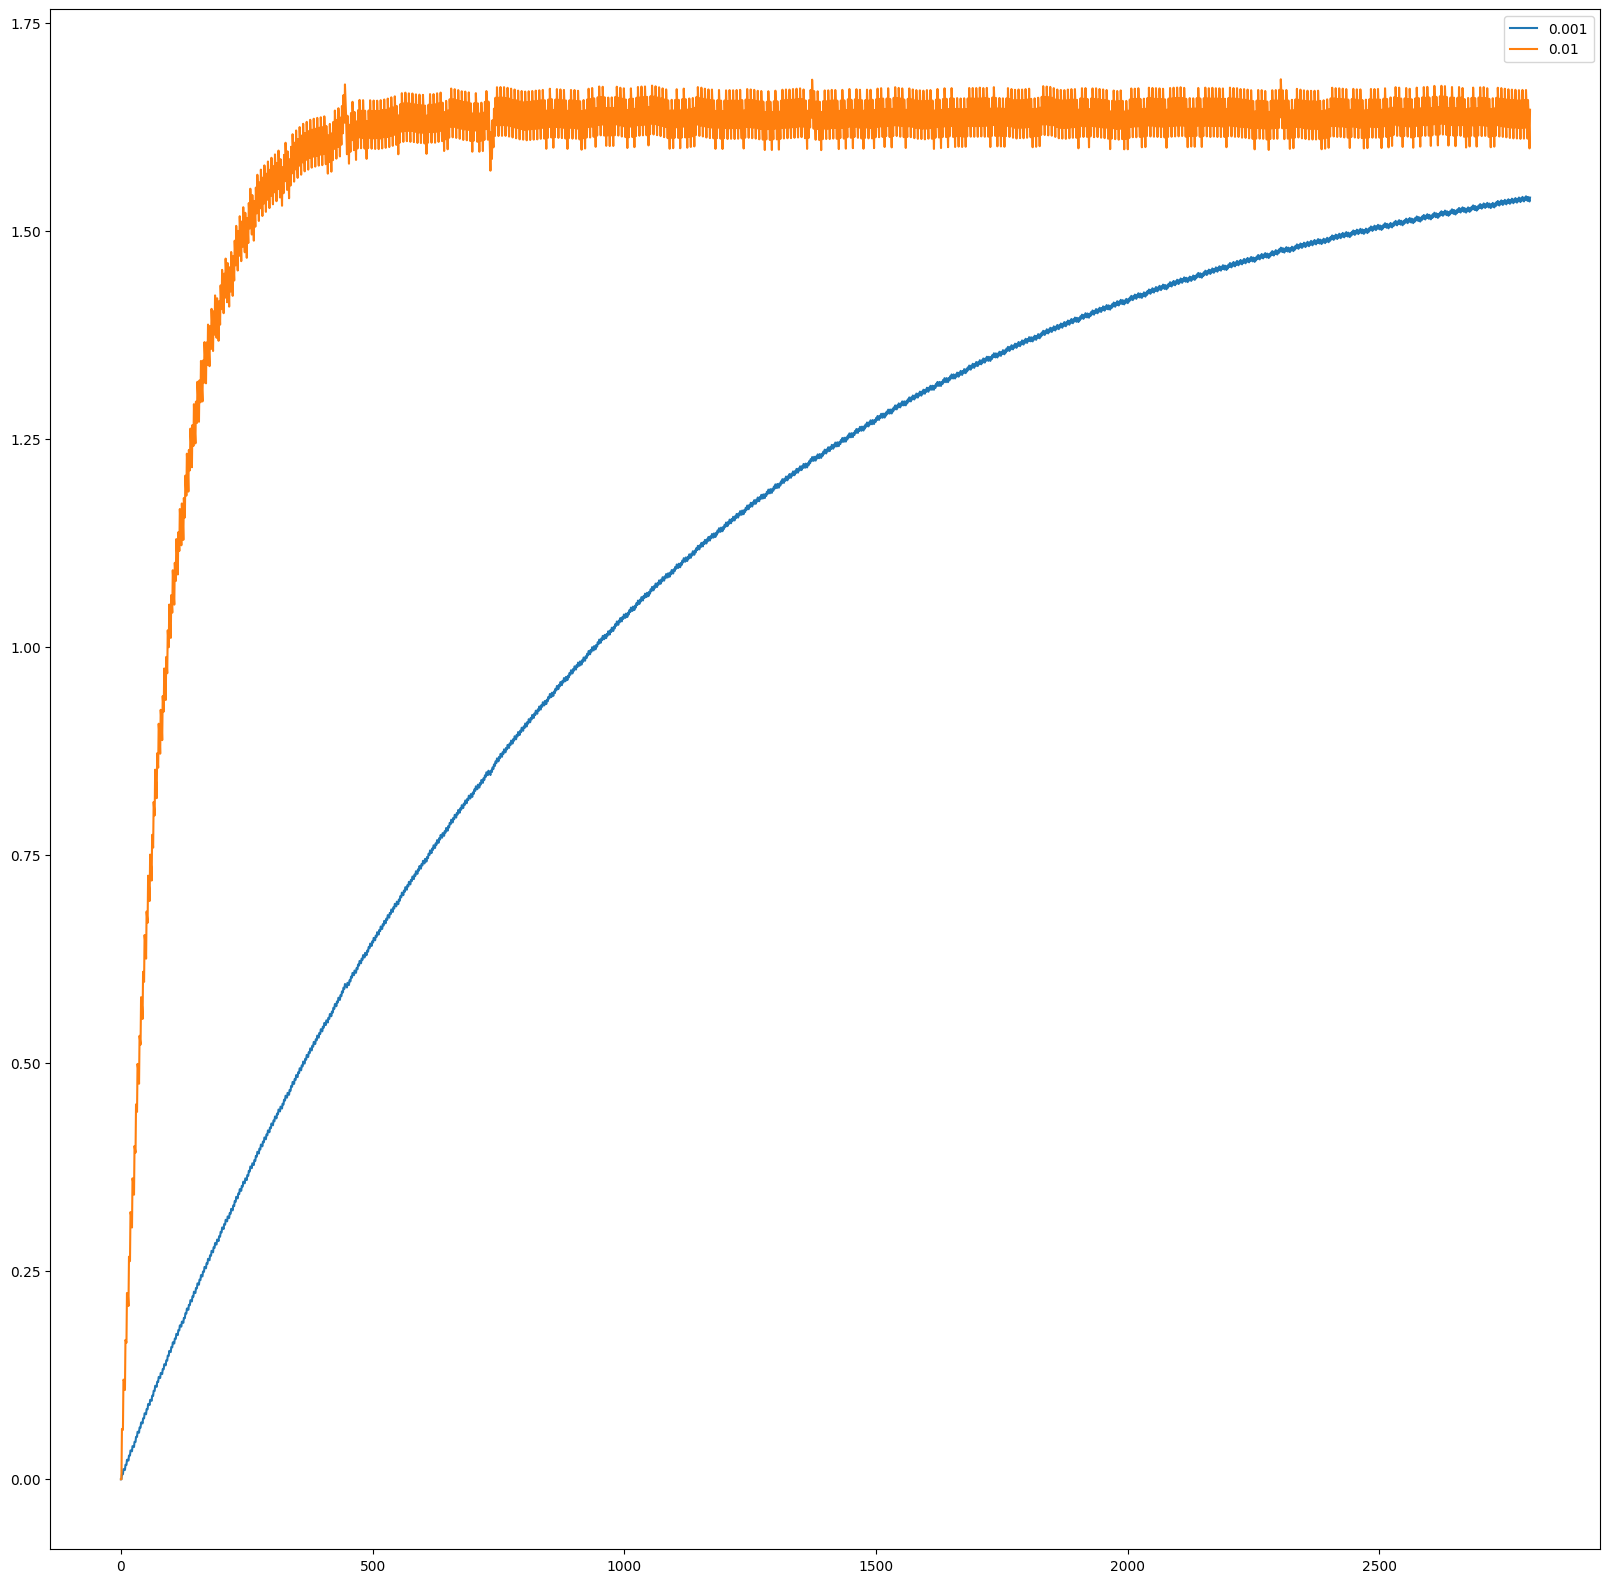

In [36]:
plt.figure(figsize=(20,20))
plt.plot(low_pass_filter(df['z'],0.001),label='0.001')
plt.plot(low_pass_filter(df['z'],0.01),label='0.01')
# plt.plot(low_pass_filter(df['z'],0.5),label='0.5')
# plt.plot(low_pass_filter(df['z'],0.6),label='0.6')
plt.legend()

0.5
0.6


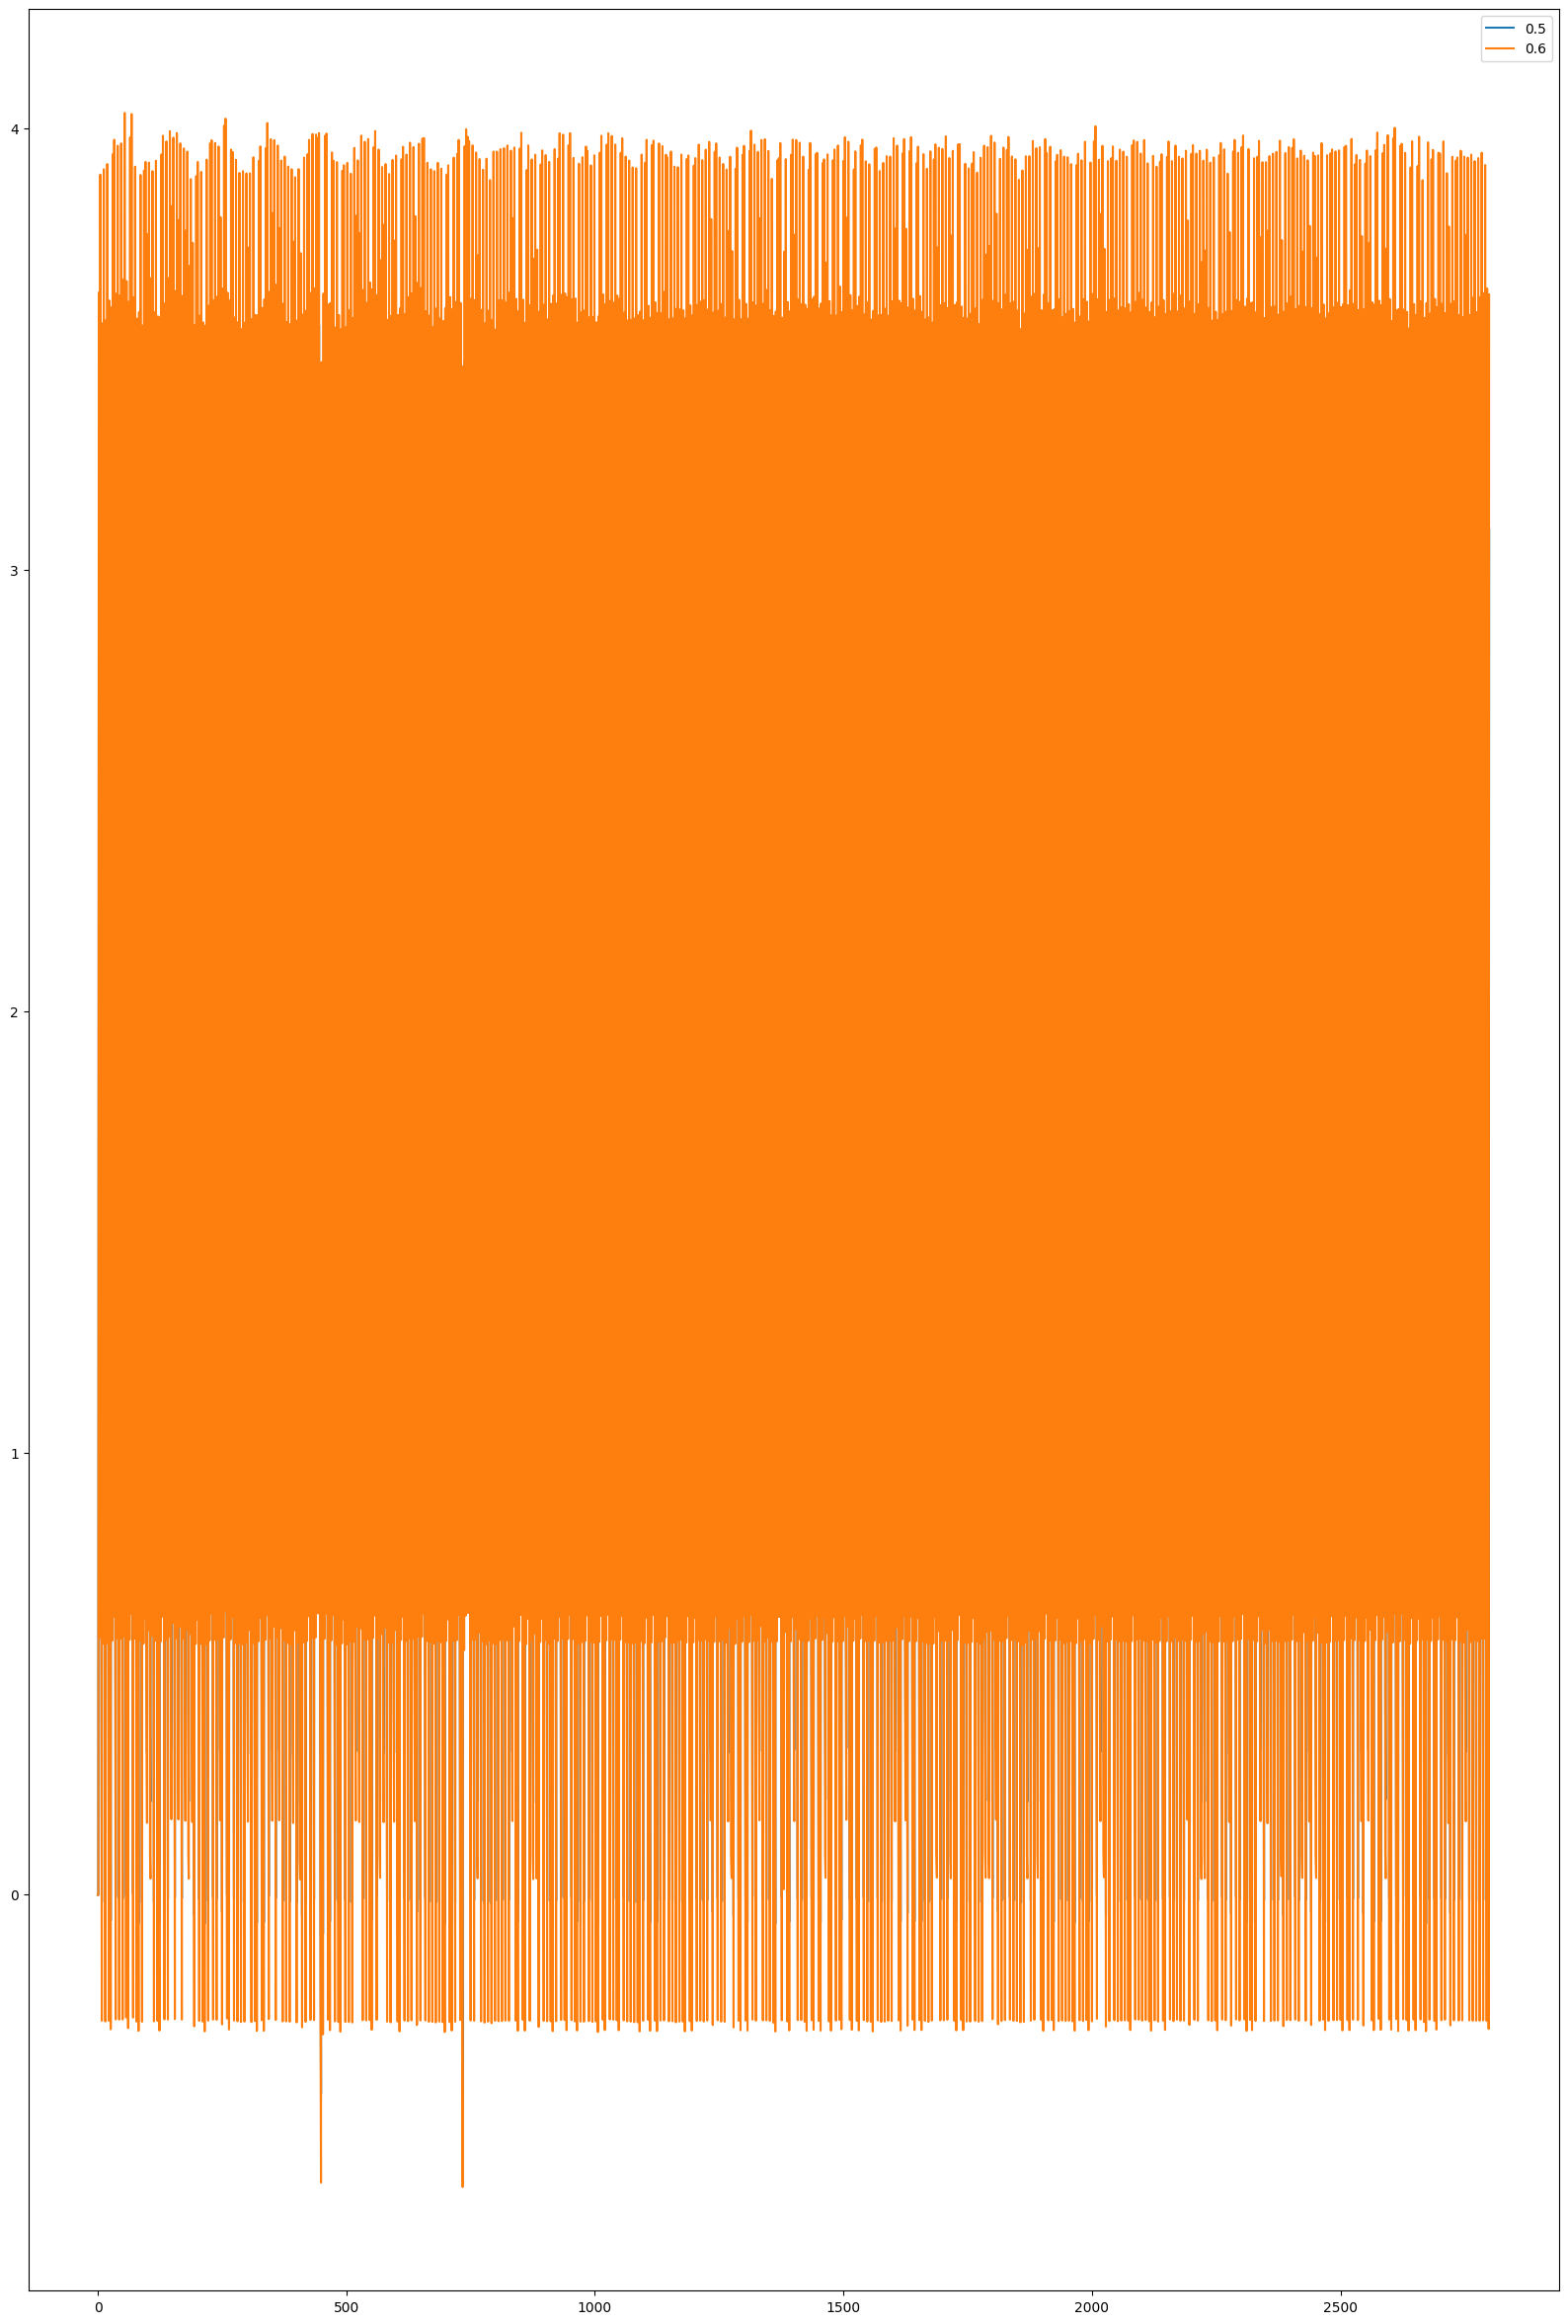

In [38]:
plt.figure(figsize=(20,30))
plt.plot(low_pass_filter(df['z'],0.5),label='0.5')
plt.plot(low_pass_filter(df['z'],0.6),label='0.6')
plt.legend()

In [28]:
print(np.mean(low_pass_filter(df['z'],0.01)))
print(np.mean(low_pass_filter(df['z'],0.5)))
print(np.mean(low_pass_filter(df['z'],0.55)))
print(np.mean(low_pass_filter(df['z'],0.6)))
print(np.mean(low_pass_filter(df['z'],0.65)))
print(np.mean(low_pass_filter(df['z'],0.7)))
print(np.mean(low_pass_filter(df['z'],0.75)))
print(np.mean(low_pass_filter(df['z'],0.8)))
print(np.mean(low_pass_filter(df['z'],0.85)))
print(np.mean(low_pass_filter(df['z'],0.9)))
print(np.mean(low_pass_filter(df['z'],0.95)))

0.01
1.5802168759495394
0.5
1.6373105230980542
0.55
1.6374361276415295
0.6
1.6375522564521692
0.65
1.6376626266911243
0.7
1.6377698231710431
0.75
1.637875655142658
0.8
1.6379813705518438
0.85
1.6380877944366492
0.9
1.6381954292009109
0.95
1.6383045381480361


<AxesSubplot: >

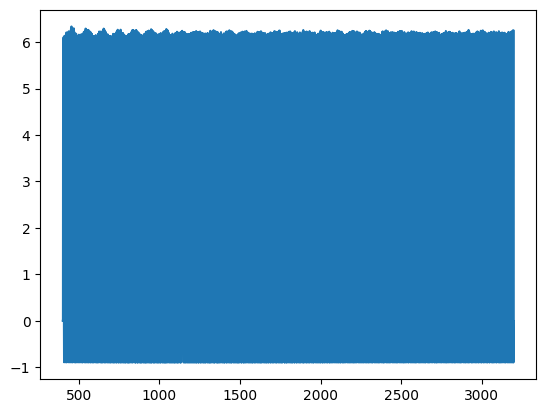

In [27]:
df['z'].plot()

In [21]:
pd.Series(low_pass_filter(df['z'],0.6)).describe()

0.6


count    2800.000000
mean        1.637552
std         1.469604
min        -0.662272
25%         0.577037
50%         1.437244
75%         3.580376
max         4.035120
dtype: float64

In [22]:
df['z'].describe()

count    2800.000000
mean        1.638415
std         2.890770
min        -0.898477
25%        -0.001419
50%         0.000259
75%         6.138466
max         6.335693
Name: z, dtype: float64

In [45]:
low_pass_filter(df['z'],0.6)

0.6


[6.135773,
 6.1271486,
 6.12729704,
 6.097189616,
 6.1131528464,
 6.11882353856,
 6.0916396154240005,
 6.0771768461696,
 6.05990233846784,
 6.080284135387136,
 6.091311454154854,
 6.112962181661942,
 6.133111872664777,
 6.144760949065911,
 6.154446779626365,
 6.176997911850546,
 6.201820564740219,
 6.208160425896088,
 6.212133970358435,
 6.250353388143374,
 6.28646955525735,
 6.29014002210294,
 6.260727408841176,
 6.27050476353647,
 6.268675505414588,
 6.261480002165835,
 6.234898800866334,
 6.214204920346534,
 6.210953568138613,
 6.221152027255446,
 6.191467010902178,
 6.149426204360871,
 6.129744281744348,
 6.1326379126977395,
 6.086389365079096,
 6.062863746031638,
 6.057051698412655,
 6.075555279365062,
 6.108810711746025,
 6.140066684698411,
 6.132464273879364,
 6.152402709551746,
 6.137398683820699,
 6.152224873528279,
 6.166056749411312,
 6.204630899764525,
 6.24088835990581,
 2.4965107439623244,
 0.9987596975849299,
 0.399284279033972,
 0.15949411161358884,
 -0.4713255553545645

## Gerr

* defining T and dt

https://stackoverflow.com/questions/17789657/alpha-value-in-removing-gravity-from-acelerometer-data#:~:text=As%20per%20the%20comment%20on,other%20side%2C%20t%20%3D%2040dt.


* removing gravity from rotating device: 

https://stackoverflow.com/questions/3377288/how-to-remove-gravity-factor-from-accelerometer-readings-in-android-3-axis-accel

In [ ]:
for i from 1 to n
  y[i] = α * y[i] + (1-α) * x[i]
return y
    val alpha: Float = 0.8f

    // Isolate the force of gravity with the low-pass filter.
    gravity[0] = alpha * gravity[0] + (1 - alpha) * event.values[0]
    gravity[1] = alpha * gravity[1] + (1 - alpha) * event.values[1]
    gravity[2] = alpha * gravity[2] + (1 - alpha) * event.values[2]

    // Remove the gravity contribution with the high-pass filter.
    linear_acceleration[0] = event.values[0] - gravity[0]
    linear_acceleration[1] = event.values[1] - gravity[1]
    linear_acceleration[2] = event.values[2] - gravity[2]

(31600, 5)


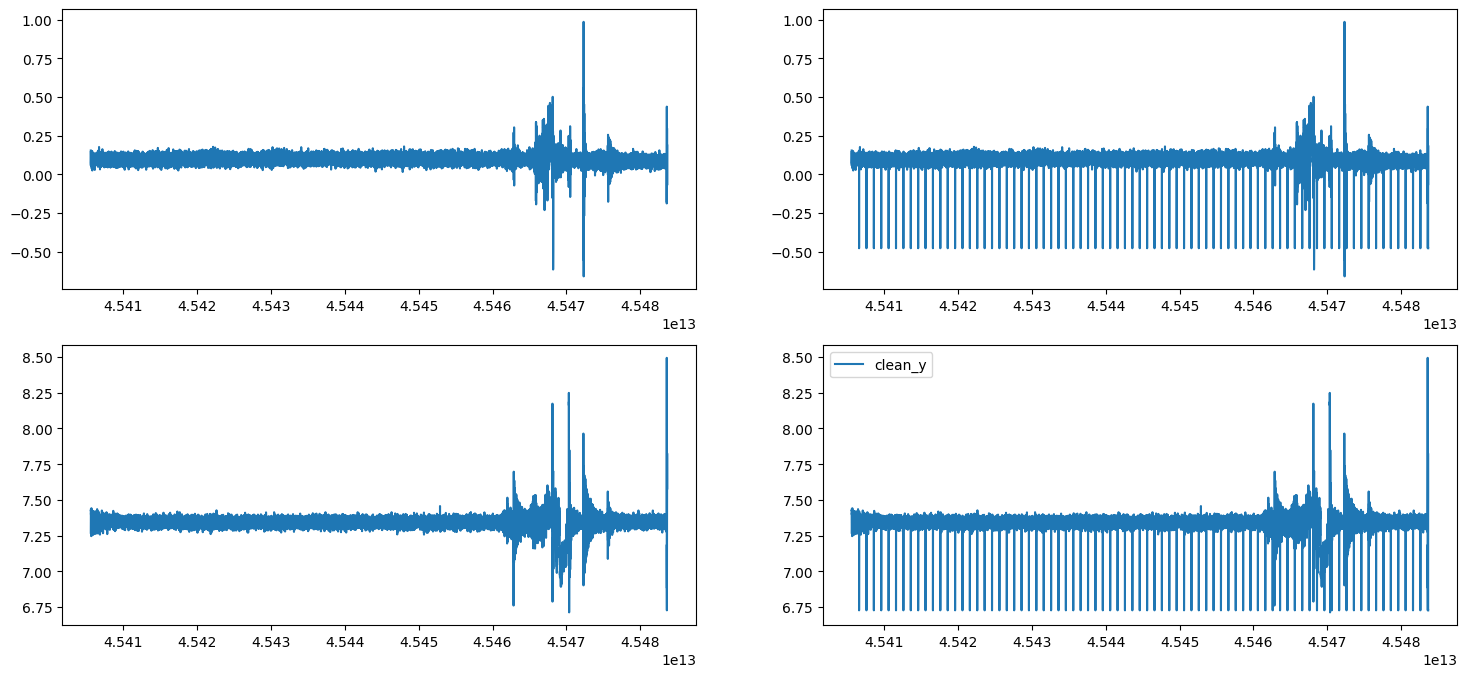

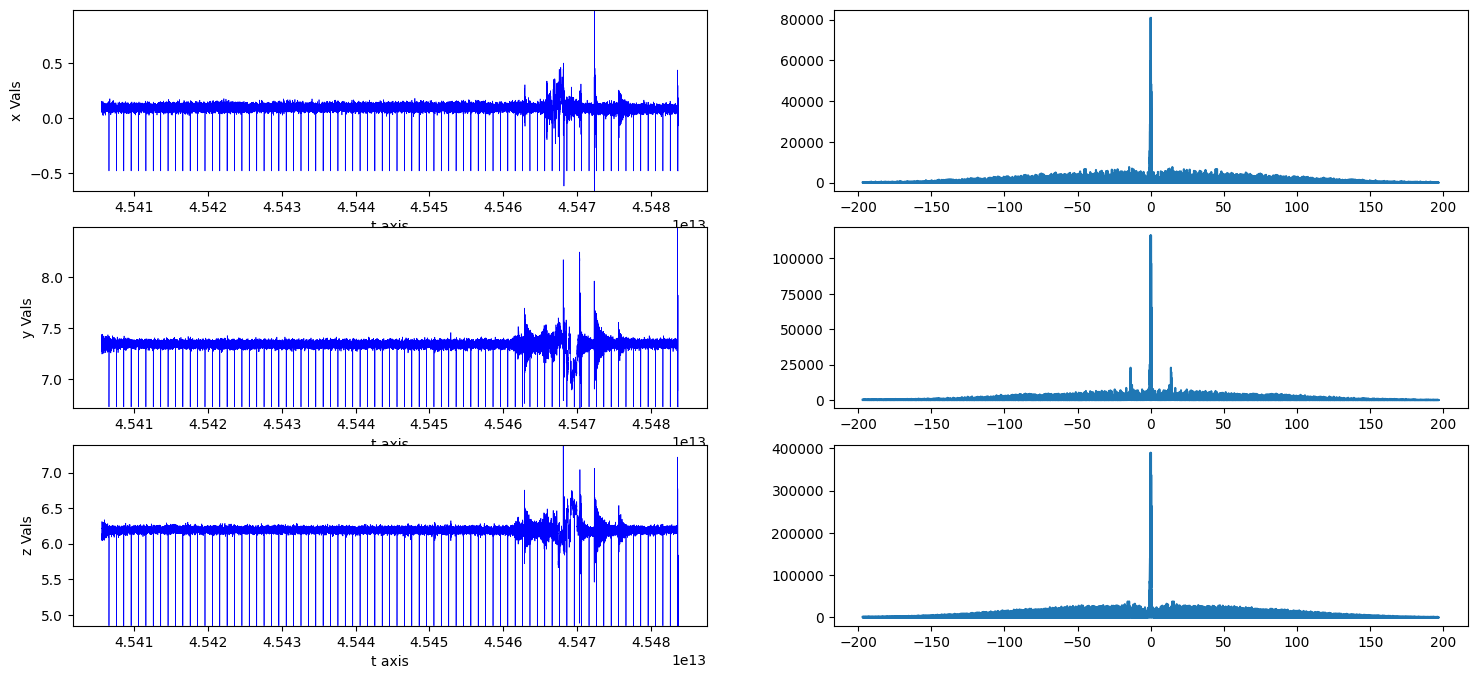

In [16]:
fig, ax = plt.subplots(2,2,figsize=(18,8))
ax[0,0].plot(df.time, df.x, label='unclean_x')
ax[0,1].plot(df2.time,df2.x,label = 'clean_x')
ax[1,0].plot(df.time, df.y, label='unclean_y')
ax[1,1].plot(df2.time,df2.y,label = 'clean_y')
plt.legend()
accs = ['x','y','z']
fig, ax = plt.subplots(3,2,figsize=(18,8))
for i in range(len(accs)):
    signal  = df2[accs[i]].values
    time  = df2['time'].values
    sample_freq,amp_freq = fft_signal(signal,avg)
    minsignal, maxsignal = signal.min(), signal.max()

    ax[i,0].plot(time, signal, color='b', lw=0.5, label='Noisy Signal')
    ax[i,0].set_ylim([minsignal, maxsignal])
    ax[i,0].set_xlabel('t axis')
    ax[i,0].set_ylabel(f'{accs[i]} Vals')
    ax[i,1].plot(sample_freq,amp_freq[0,:],label = 'psd')
# fig.savefig('output/stationary')

###  Pretreat df:filling the missing data with smallest deltaT within the second

(31600, 5)


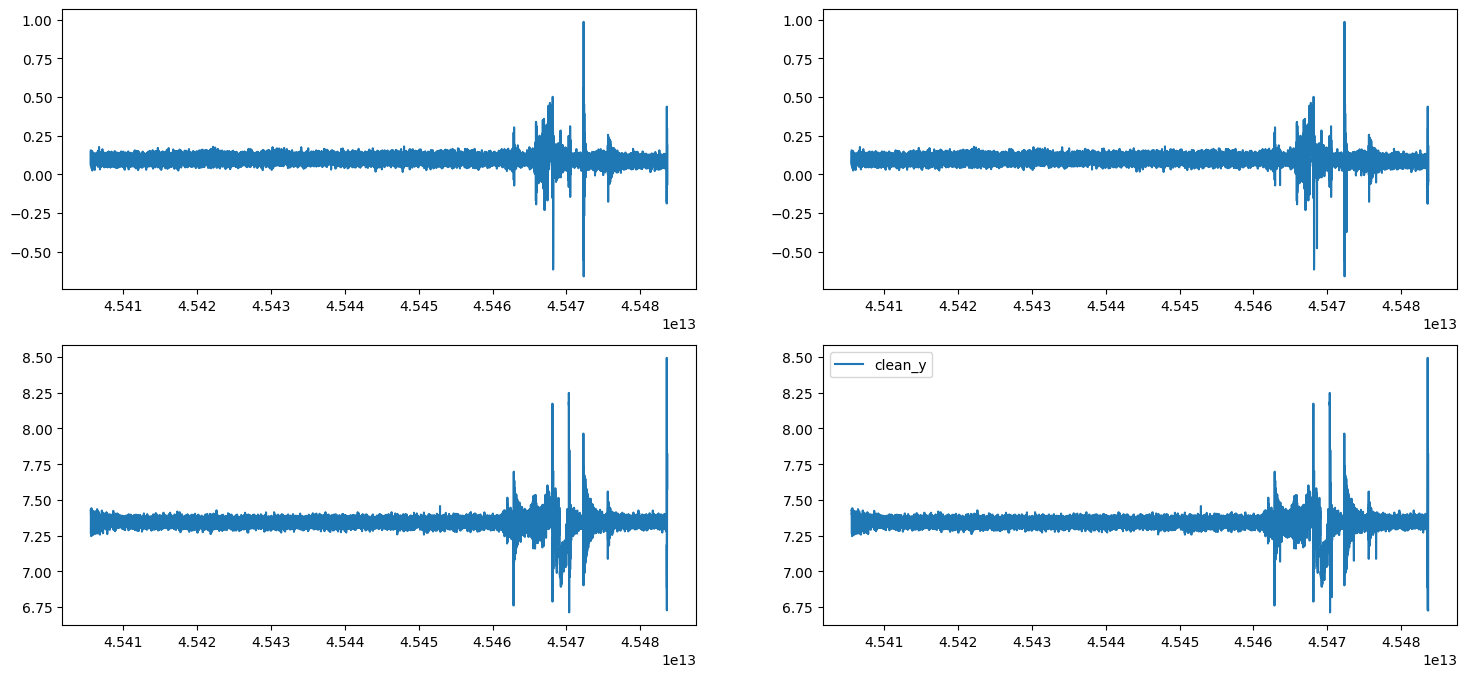

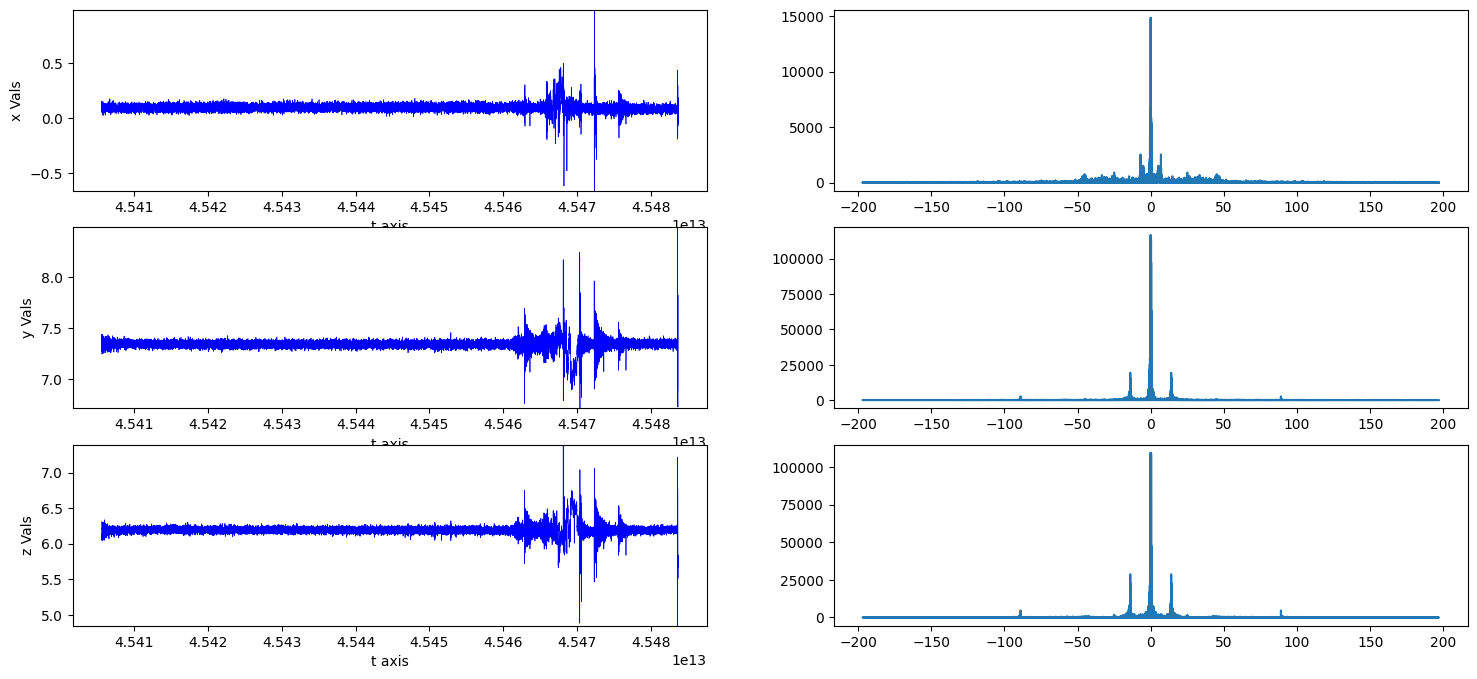

In [17]:

df2 = pd.DataFrame({'time':[],'x':[],'y':[],'z':[]})
n = df['time'].iloc[0]


while (n < df['time'].iloc[-1]):
    recs = df[(df['time'] >=n) & (df['time']<n+ 1e+9)].copy()
    x = list(np.diff(np.diff(recs['time'])))
    x.insert(0,0)
    x.insert(0,0)
    recs['time_diff'] = x 
    desc = recs[recs['time_diff']==0].describe().T[['mean','min','50%']].T 
    # df2.iloc[counter:counter + len(recs)] = recs
    df2 = pd.concat([df2,recs],axis=0)
    if len(recs) < 400:
        t = 400-len(recs)
        # filling the missing data with smallest deltaT within the sec
        recs = pd.DataFrame({'time':np.arange(df2['time'].iloc[-1]+1,df2['time'].iloc[-1]+t+1),'x':[desc['x']['min']]*t,'y':[desc['y']['min']]*t,'z':[desc['z']['min']]*t}) # 
        # df2.iloc[counter + len(recs):counter + len(recs) + (400-len(recs))] = 0
        df2 = pd.concat([df2,recs],axis=0)
    n= n+1e+9
print(df2.shape)
df2.to_csv('cleaned_stationary_df.csv',index=False)
fig, ax = plt.subplots(2,2,figsize=(18,8))
ax[0,0].plot(df.time, df.x, label='unclean_x')
ax[0,1].plot(df2.time,df2.x,label = 'clean_x')
ax[1,0].plot(df.time, df.y, label='unclean_y')
ax[1,1].plot(df2.time,df2.y,label = 'clean_y')
plt.legend()
accs = ['x','y','z']
fig, ax = plt.subplots(3,2,figsize=(18,8))
for i in range(len(accs)):
    signal  = df2[accs[i]].values
    time  = df2['time'].values
    sample_freq,amp_freq = fft_signal(signal,avg)
    minsignal, maxsignal = signal.min(), signal.max()

    ax[i,0].plot(time, signal, color='b', lw=0.5, label='Noisy Signal')
    ax[i,0].set_ylim([minsignal, maxsignal])
    ax[i,0].set_xlabel('t axis')
    ax[i,0].set_ylabel(f'{accs[i]} Vals')
    ax[i,1].plot(sample_freq,amp_freq[0,:],label = 'psd')
# fig.savefig('output/stationary')

* The plots looks much similar now, but new peaks (actually downward peaks) are visible near previous peaks
* peaks has been retained in fft plots

### breakdown

200.0 31600
threshold is:  50


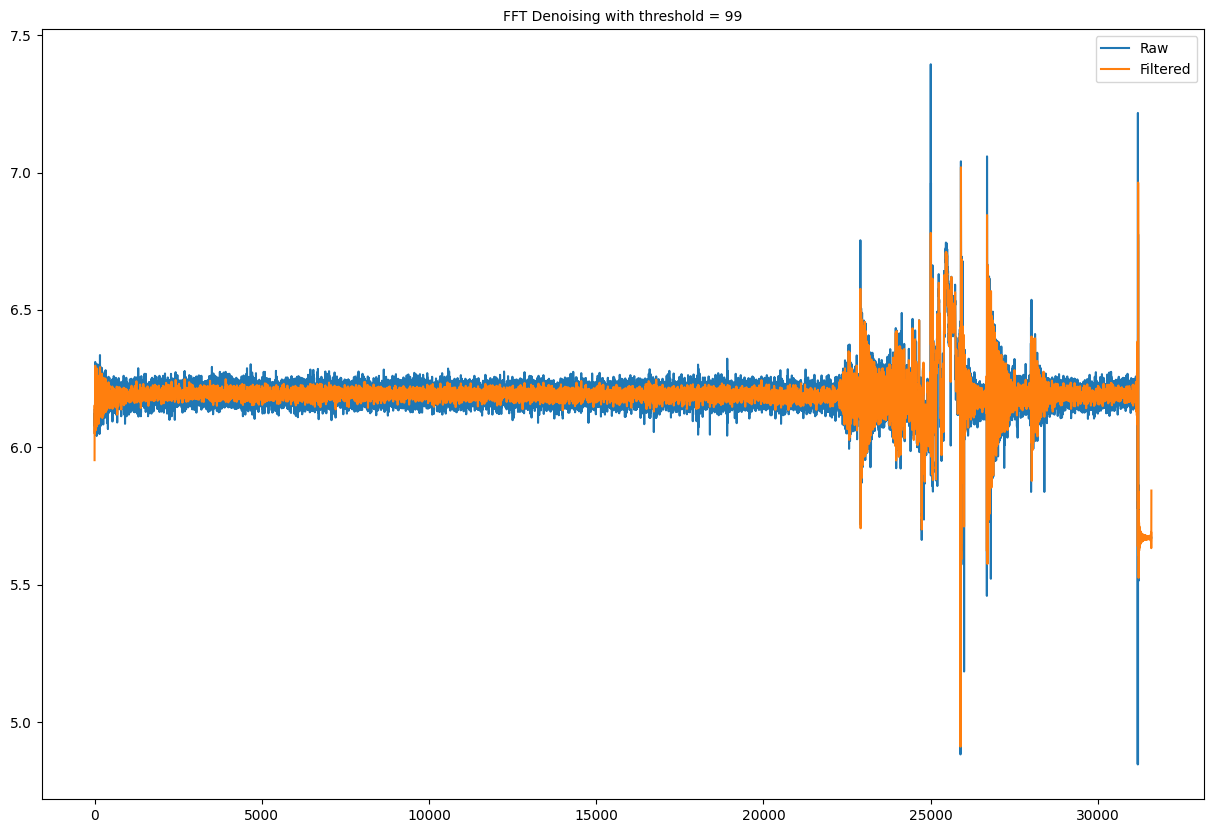

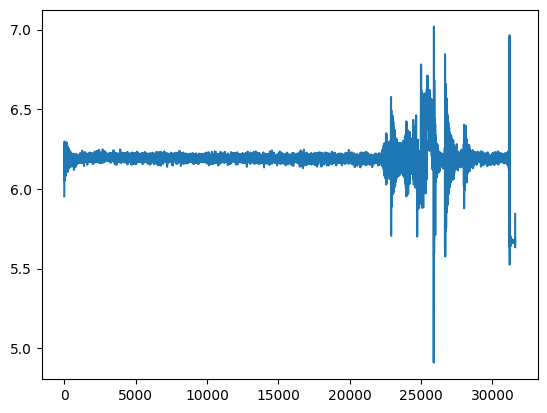

In [18]:
signal = df2['z'].values
filtered = filtered_sig(signal,1./400,50)

plt.figure(figsize=(15, 10))
plt.plot(signal, label='Raw')
plt.plot(filtered, label='Filtered')
plt.legend()
plt.title(f"FFT Denoising with threshold = {99}", size=10)
plt.show()
plt.plot(filtered, label='Filtered')
plt.show()

* plot1: filtered signal of z with thresh: 50 and raw signal
* plot2: filtered signal of z

### inverse fft

In [19]:
cols = ['x','y','z']
df = pd.DataFrame()
for i in cols:
    signal = df2[i].values
    filtered = filtered_sig(signal,1./400,50)
    df[i] = filtered


200.0 31600
threshold is:  50
200.0 31600
threshold is:  50
200.0 31600
threshold is:  50


In [20]:
df['time'] = list(df2['time'])
df.head()

,x,y,z,time
0,0.057542,7.109139,5.953284,4.540560e+13
1,0.074454,7.262906,6.053043,4.540561e+13
2,0.080823,7.378976,6.122891,4.540561e+13
3,0.081490,7.442690,6.153003,4.540561e+13
4,0.083279,7.457033,6.145802,4.540561e+13


In [49]:
df.to_csv('fitered_stationary_data.csv',index=False)

# Distance calculation

In [ ]:
df = pd.read_csv('./fitered_stationary_data.csv')
df.head()

,x,y,z,time
0,0.057542,7.109139,5.953284,4.540560e+13
1,0.074454,7.262906,6.053043,4.540561e+13
2,0.080823,7.378976,6.122891,4.540561e+13
3,0.081490,7.442690,6.153003,4.540561e+13
4,0.083279,7.457033,6.145802,4.540561e+13


In [ ]:
df['acc'] = np.sqrt(df['x']*df['x'] + df['y']*df['y'] + df['z']+df['z'])

In [15]:
df

,time,x,y,z,time_diff
0,45405604266664,0.154587,7.270157,6.135773,0
1,45405606769106,0.113876,7.368317,6.121399,0
2,45405609271547,0.057617,7.419800,6.127396,-1
3,45405611773989,0.067200,7.394653,6.077118,1
4,45405614277065,0.061203,7.393463,6.123795,634
...,...,...,...,...,...
108706,45483644814313,-0.069275,7.825607,5.655731,30517
108710,45483647316754,-0.001038,7.786102,5.514481,-30518
108713,45483649819196,0.049240,7.735825,5.515671,1
108716,45483652321637,0.173737,7.653229,5.659317,-1


In [ ]:
dist = 0.0 # meters
ini_vel = 0.0

for i in range(1,len(df)):
    interval  = (df.iloc[i]['time'] - df.iloc[i-1]['time']) / 1e+9
    fin_vel  = ini_vel + (df.iloc[i]['acc']*interval) #u+at
    dist += (ini_vel*interval) + 0.5*df.iloc[i]['acc']*interval*interval #ut+0.5*at^2
    ini_vel= fin_vel

In [ ]:
print(dist,ini_vel)

24802.60952299914 635.4655351547453


# walking data

In [38]:
df  =pd.read_csv('/Users/atufasheen/Desktop/projects/meiro_work/EP2_Phone in hand_Walking slowly.csv',
                    sep=';',names=['time','type','x','y','z','ang_x','ang_y','ang_z'])
df=df[df['type']==' ACC'][['time','x','y','z']]

385 72


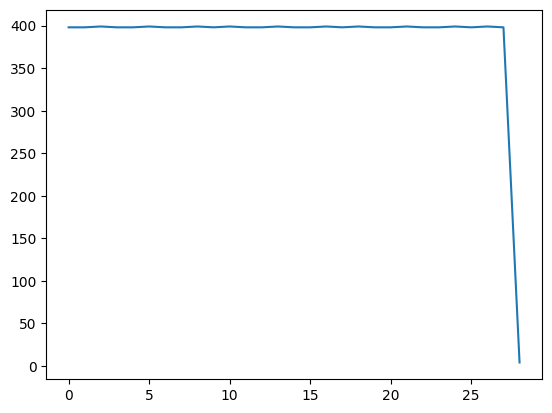

In [39]:
avg,std  = cyc_sec(df['time'])
print(avg,std)

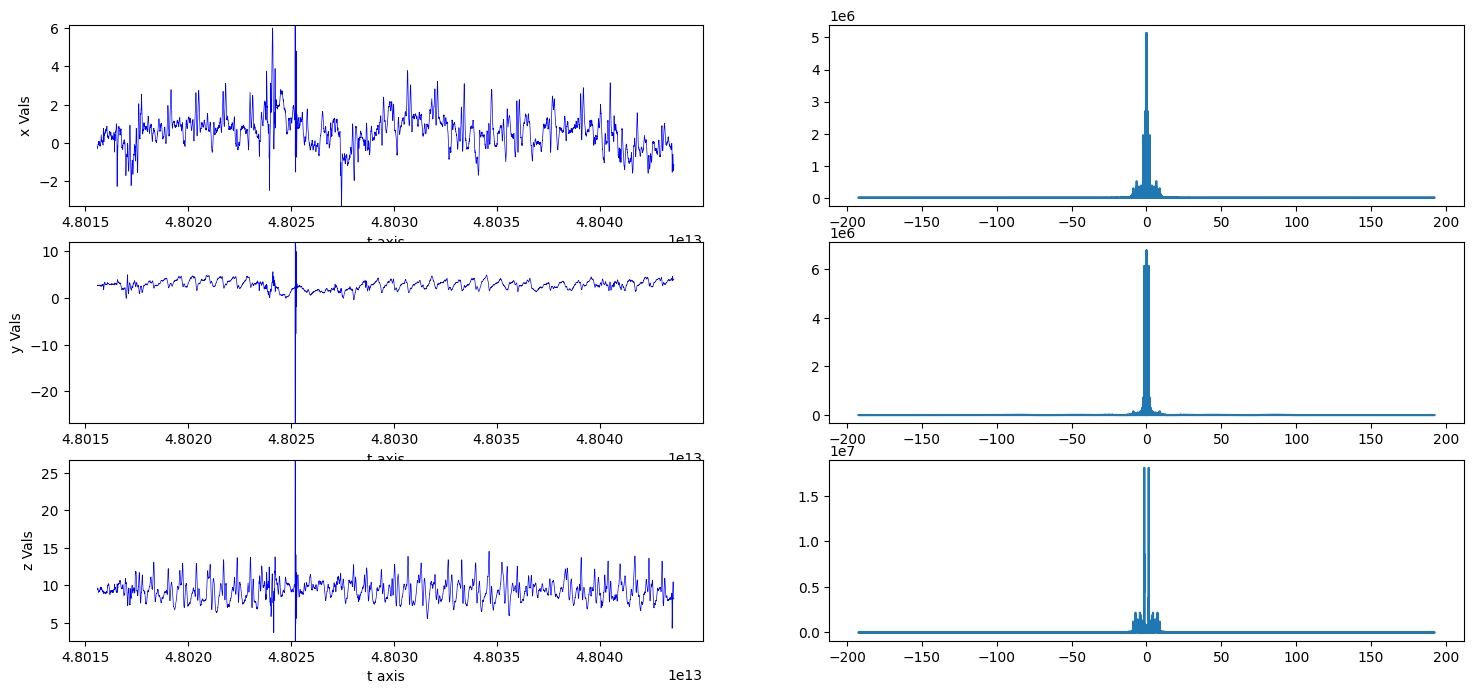

In [116]:
accs = ['x','y','z']
fig, ax = plt.subplots(3,2,figsize=(18,8))
for i in range(len(accs)):
    signal  = df[accs[i]].values
    time  = df['time'].values
    sample_freq,amp_freq = fft_signal(signal,avg)
    minsignal, maxsignal = signal.min(), signal.max()

    ax[i,0].plot(time, signal, color='b', lw=0.5, label='Noisy Signal')
    ax[i,0].set_ylim([minsignal, maxsignal])
    ax[i,0].set_xlabel('t axis')
    ax[i,0].set_ylabel(f'{accs[i]} Vals')
    ax[i,1].plot(sample_freq,amp_freq[0,:],label = 'psd')
# fig.savefig('output/stationary')

# treated walking_data

###  Pretreat df: filling the missing data with smallest deltaT within the second

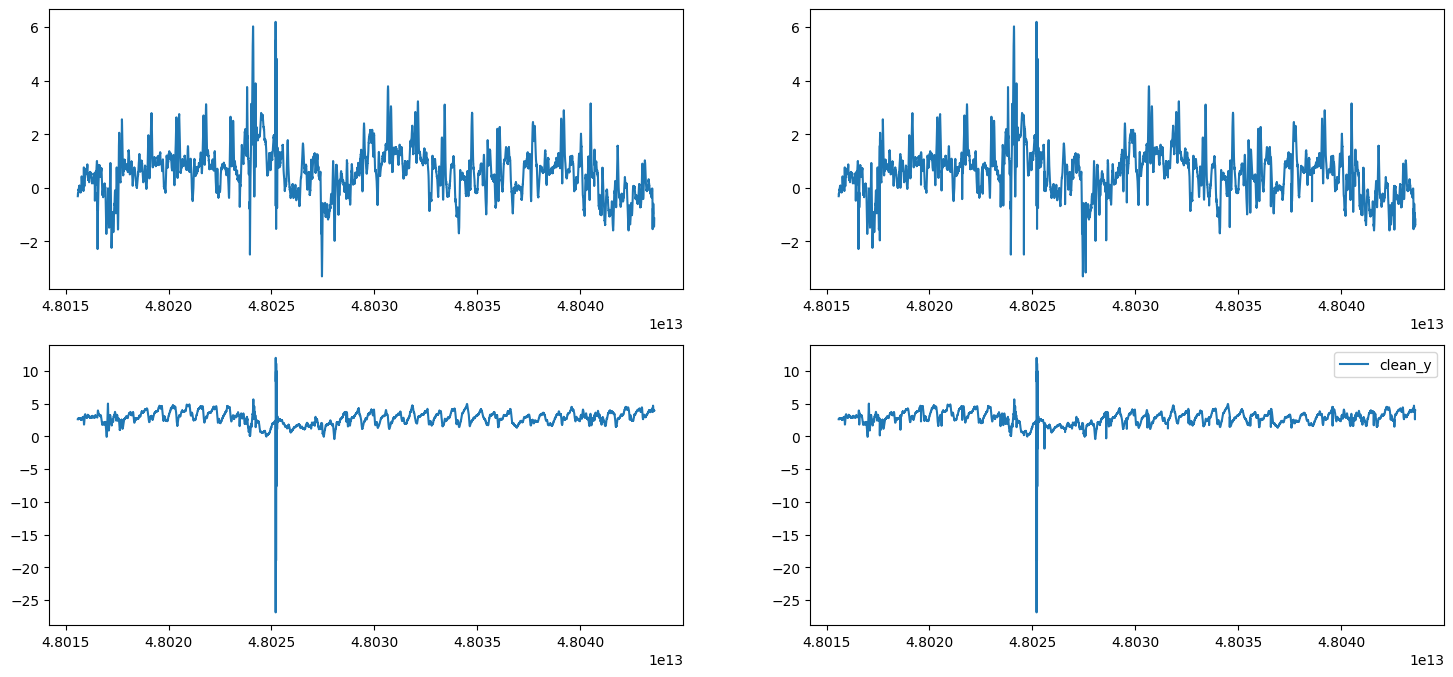

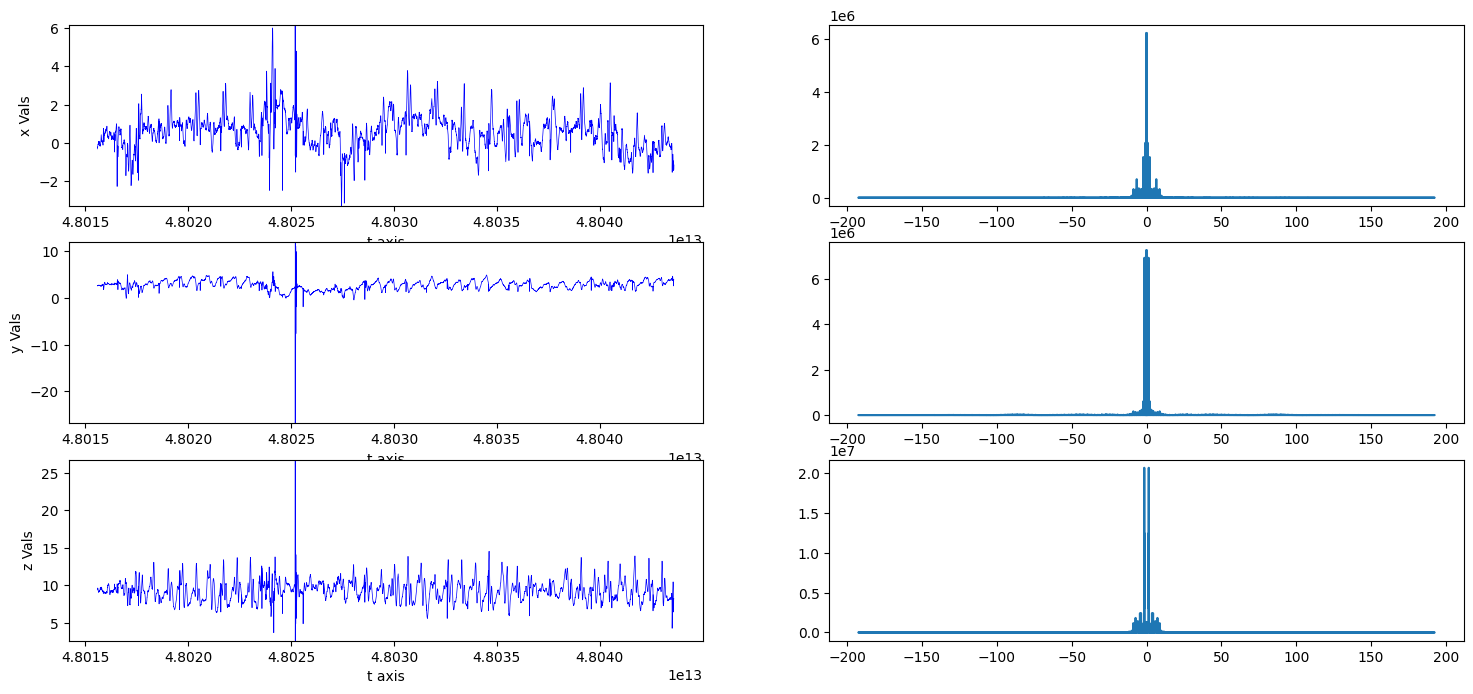

In [40]:

df2 = pd.DataFrame({'time':[],'x':[],'y':[],'z':[]})
n = df['time'].iloc[0]


while (n < df['time'].iloc[-1]):
    recs = df[(df['time'] >=n) & (df['time']<n+ 1e+9)].copy()
    x = list(np.diff(np.diff(recs['time'])))
    x.insert(0,0)
    x.insert(0,0)
    recs['time_diff'] = x 
    desc = recs[recs['time_diff']==0].describe().T[['mean','min','50%']].T
    # df2.iloc[counter:counter + len(recs)] = recs
    df2 = pd.concat([df2,recs],axis=0)
    if len(recs) < 400:
        t = 400-len(recs)
        recs = pd.DataFrame({'time':np.arange(df2['time'].iloc[-1]+1,df2['time'].iloc[-1]+t+1),'x':[desc['x']['min']]*t,'y':[desc['y']['min']]*t,'z':[desc['z']['min']]*t}) # 
        # df2.iloc[counter + len(recs):counter + len(recs) + (400-len(recs))] = 0
        df2 = pd.concat([df2,recs],axis=0)
    n= n+1e+9
# df2.to_csv('cleaned_walking_df.csv',index=False)
fig, ax = plt.subplots(2,2,figsize=(18,8))
ax[0,0].plot(df.time, df.x, label='unclean_x')
ax[0,1].plot(df2.time,df2.x,label = 'clean_x')
ax[1,0].plot(df.time, df.y, label='unclean_y')
ax[1,1].plot(df2.time,df2.y,label = 'clean_y')
plt.legend()
accs = ['x','y','z']
fig, ax = plt.subplots(3,2,figsize=(18,8))
for i in range(len(accs)):
    signal  = df2[accs[i]].values
    time  = df2['time'].values
    sample_freq,amp_freq = fft_signal(signal,avg)
    minsignal, maxsignal = signal.min(), signal.max()

    ax[i,0].plot(time, signal, color='b', lw=0.5, label='Noisy Signal')
    ax[i,0].set_ylim([minsignal, maxsignal])
    ax[i,0].set_xlabel('t axis')
    ax[i,0].set_ylabel(f'{accs[i]} Vals')
    ax[i,1].plot(sample_freq,amp_freq[0,:],label = 'psd')
# fig.savefig('output/stationary')

* walking data doesnot have peaks as in stationary data
* walking fft plot seems to have no noise

# finding peaks
try:

z-score one: https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data

scipy one: https://stackoverflow.com/questions/35282456/find-local-maximums-in-numpy-array

find_peaks_cwt
Find peaks using the wavelet transformation.

peak_prominences
Directly calculate the prominence of peaks.

peak_widths
Directly calculate the width of peaks.

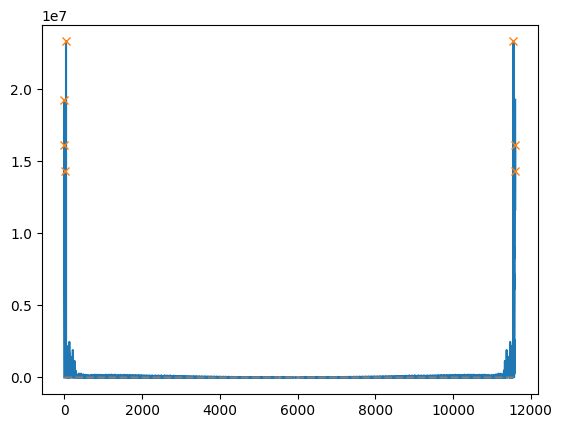

In [128]:
def reject_outliers(x,m = 2.):
    m = 2.
    data = amp_freq[0,:]
    d = np.abs(x - np.median(x))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return True if s<m else False


x = amp_freq[0,:]
# x = sample_freq
from scipy.signal import find_peaks
peaks, _ = find_peaks(x, height=np.percentile(x,99.9))
plt.plot(x,)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [38]:
y[19473], y[19472]
import scipy
g = scipy.signal.argrelextrema(x, np.greater)
len(g[0])
import numpy as np
y = amp_freq[0,:]
slope = [np.sign(y[i]-y[i-1]) for i in range(1, len(y))]

(807.0175338908939, 144.55791023403862)